## Import Packages and define plotting function

In [19]:
import os
import sys
import inspect
import numpy as np
import errno

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

import pandas as pd
import random as rn
from itertools import cycle
import time
from collections import OrderedDict

In [20]:
from looti import emulatorpaths as epath

from looti  import tools as too
from looti  import interpolators as itp

from looti import dataplotters as dtp

from looti import dictlearn as dcl

from looti import datahandle as dhl

#sns.set()

In [21]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def Plot_prediction(emulation_data, paramvalue_predicted, ratios_predicted) :
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    for tt in emulation_data.train_samples:

        ax[0].semilogx(k_grid,ratio_train_dict[tt],'-o', color='blue', lw=1, ms=1, markevery=1, 
             alpha=0.8, label="Training Ratio param = "+str(tt))


    ax[0].semilogx(k_grid,ratio_test_dict[paramvalue],'-v', color='red', lw=1, ms=1, markevery=1, 
             alpha=0.8, label="Actual Ratio param = "+str(paramvalue))
    ax[0].semilogx(k_grid,ratios_predicted[0.10],'-s', color='green', lw=1, ms=2, markevery=1, 
             alpha=0.8, label="Predicted Ratio param = "+str(paramvalue))


    ax[0].legend(loc='upper left')
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')

    ax[1].semilogx(k_grid,1-ratios_predicted[paramvalue]/ratio_test_dict[paramvalue],'-v', 
               color='purple', lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Ratio of Ratios param = "+str(paramvalue))





# Run Parameters

## Import Data

The data correspond to the frames containing the power matter spectrum or ratios at different redshift and for different parameters. These frames have a standard format that can be automatically constructed with the notebook read_files.

The data must be organised in the following way :
- One folder containing the whole data : datafolder
- One input folder contaning the input data : power matter spectrum/ratios. Usually there is two files one containing the LCDM p_ks as a reference, and one containing the p_ks of experiments e.g CDE, F(R), MassivNus
- One output folder that will containing the results (plots) of the predictions

In [23]:
datafolder = '../../optimaltransport/'

###The name of folder where the input are
inputfolder=datafolder+'codec_website_data/' 

###The name of folder where the output are
outputfolder=datafolder+'codec_website_interpolations/'



# Load Codec Ratio

The user must provide : 
- datafile_ext : the file's name containing the power spectrum/ratios of (CDE,F(R),MassivNus,...)
- datafile_lc : the file's name containing the power spectrum/ratios of LCDM which will be taken as a reference

In [24]:
###Name of the file for the external input data
datafile_exp = 'Codec_EXP_reformat'
print(datafile_exp)

###Name of the file for the LCDM input data
datafile_lc = 'Codec_LCDM'
print(datafile_lc)

Codec_EXP_reformat
Codec_LCDM


In [25]:
emulation_data = dhl.DataHandle( datafile_exp, inputfolder, datafile_lc,multindex_cols_ref=[0,1]) 
emulation_data.read_csv_pandas() 



Shape of imported reference model dataframe:  (2, 63)
Shape of imported extended model dataframe:  (4, 63)


Ratios are computed at a given redshift. User should provide, the redshift chosen.
The function calculate_ratio_data will compute the ratios at this redshift : datafile_ext/datafile_lc.
If ratios_mode = True : datafile is directly used to obtains the ratios.

In [26]:
###Redshift
z_choice = 0
###Estimate ratio at redshift z = 0
emulation_data.calculate_ratio_data(z_choice)

User should change the number of training vectors, wanted test vector. If cross-validation is wanted, number_of_spltis should be greater that one. 

In [27]:
n_train = 0 # Number of training vectors without taking acount the extrema 
n_test = 1 # Number of test vectors without taking acount the extrema
n_splits = 1  # Number of splits

# Define number of training and test

The user should not change anything here except verbosity. 
- calculate_data_split will find the indexes of train,validation and test vectors.
- data_split will split the data into train,validation and test vectors by using the indexes calculated before.

If the number of training vectors + number of test vectors is equals to the number of samples then there will be no validation vectors.

In [28]:
emulation_data.calculate_data_split(n_train=n_train, n_test=n_test, 
                                    n_splits=n_splits, verbosity=0,num_percentiles=5);
emulation_data.data_split(split_index=0,verbosity=0);

# PCA Example

User should provide here the number of components. The following code will create the interpolator object, perfom PCA, interpolate the training data and predict the values of the test samples


Choose number of components

In [29]:
npca = 2

('Shape of PCA matrix: (2, 2)',)
('Number of PCA components: 2',)
 global mean min error:  0.0 
 global mean max error:  0.024788719086215973 
 global max rmse:  0.011644739039240645 
 global mean rmse:  0.011644739039240645 
 global var rmse:  0.0


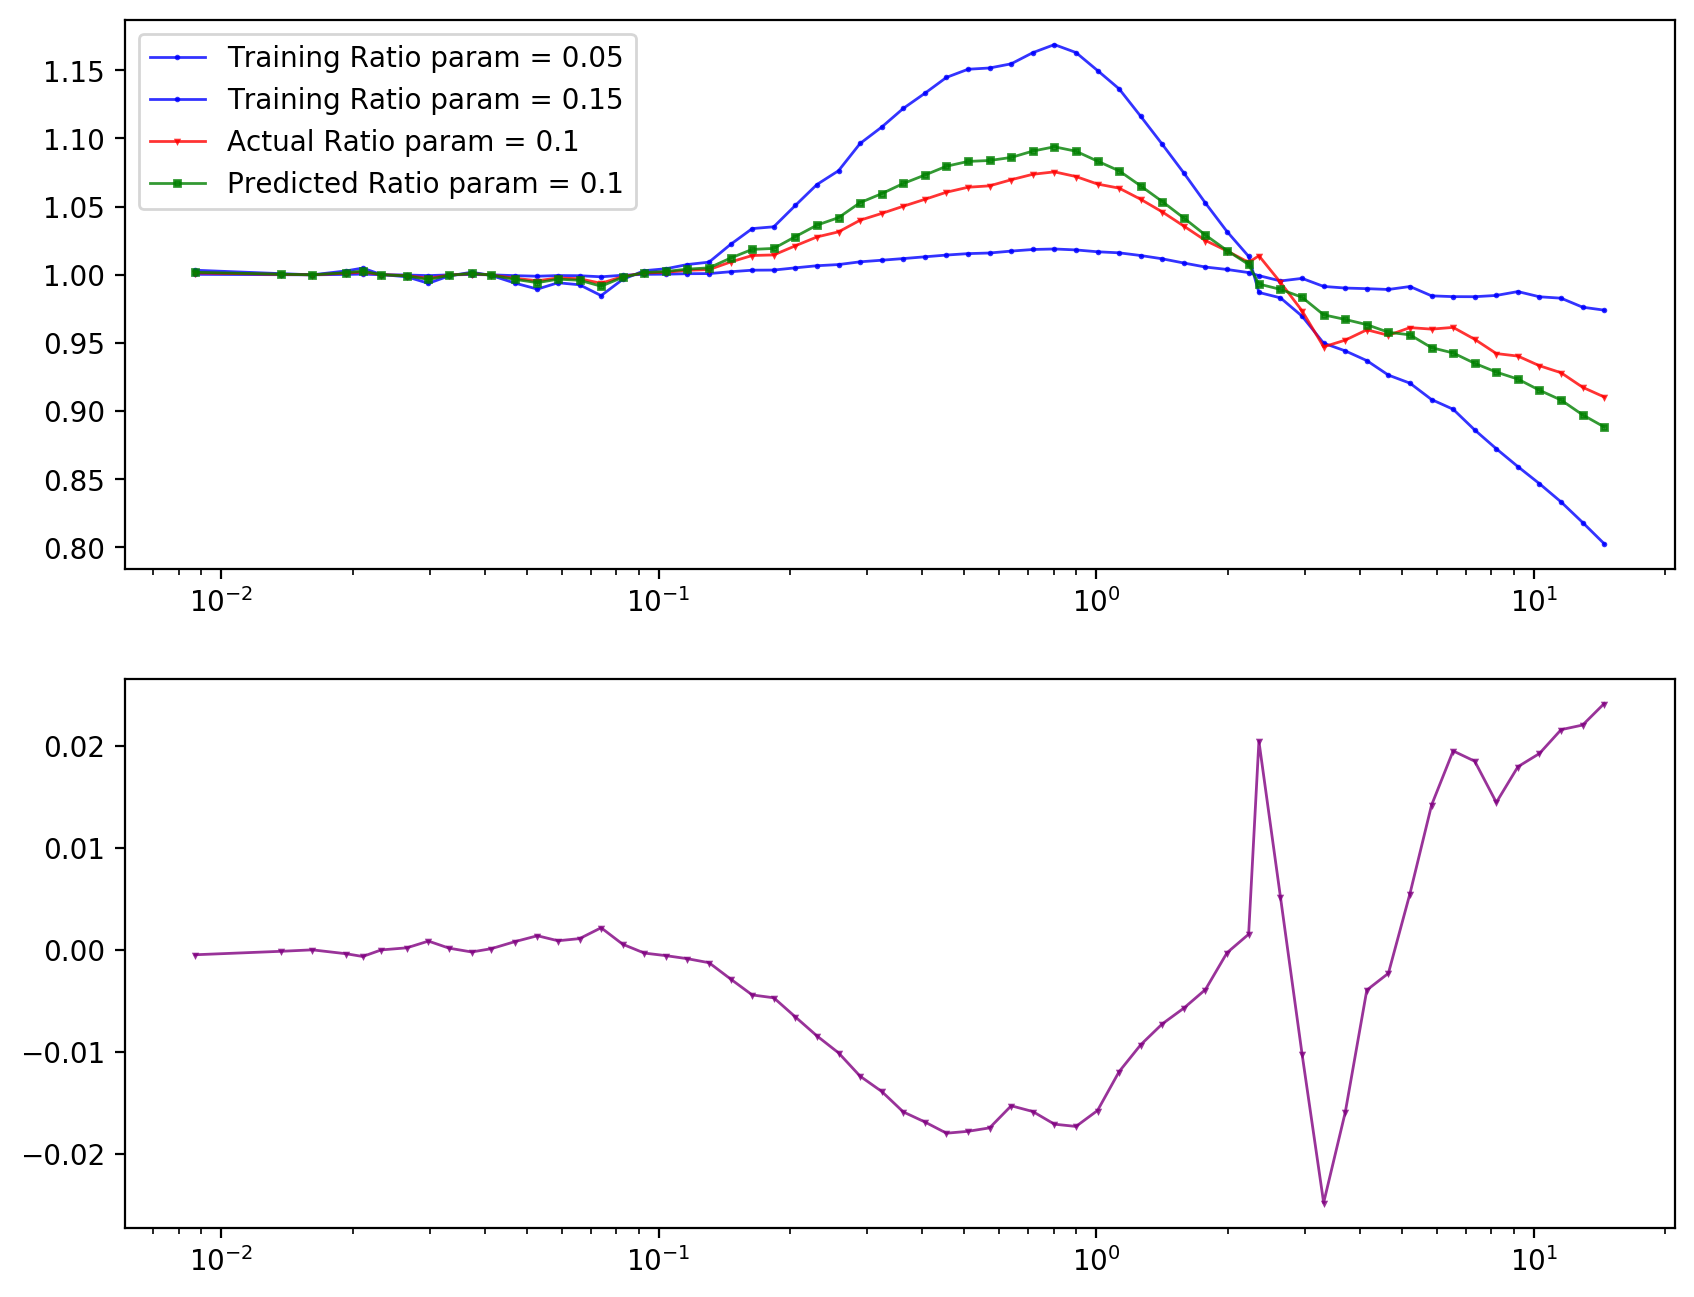

In [30]:
###PCA and interpolation###
###Creating the PCA operator 
PCAop = dcl.LearningOperator('PCA', ncomp=npca, interp_type='int1d')
intobj = dcl.LearnData(PCAop)

###Perfoming the PCA reduction and interpolation 
intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted)
intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
                
intobj.print_statistics()

# PCA Example

The following example used a mask to ignore the value before k<0.1 

('number of wanted training vectors', 0)
('number of wanted test vectors', 1)
('number of obtained training vectors', 2)
('number of obtained validation vectors', 0)
('number of obtained test vectors', 1)
('Shape of PCA matrix: (2, 2)',)
('Number of PCA components: 2',)
 global mean min error:  0.00028263619378043854 
 global mean max error:  0.024788719086215973 
 global max rmse:  0.013769180312844784 
 global mean rmse:  0.013769180312844784 
 global var rmse:  0.0


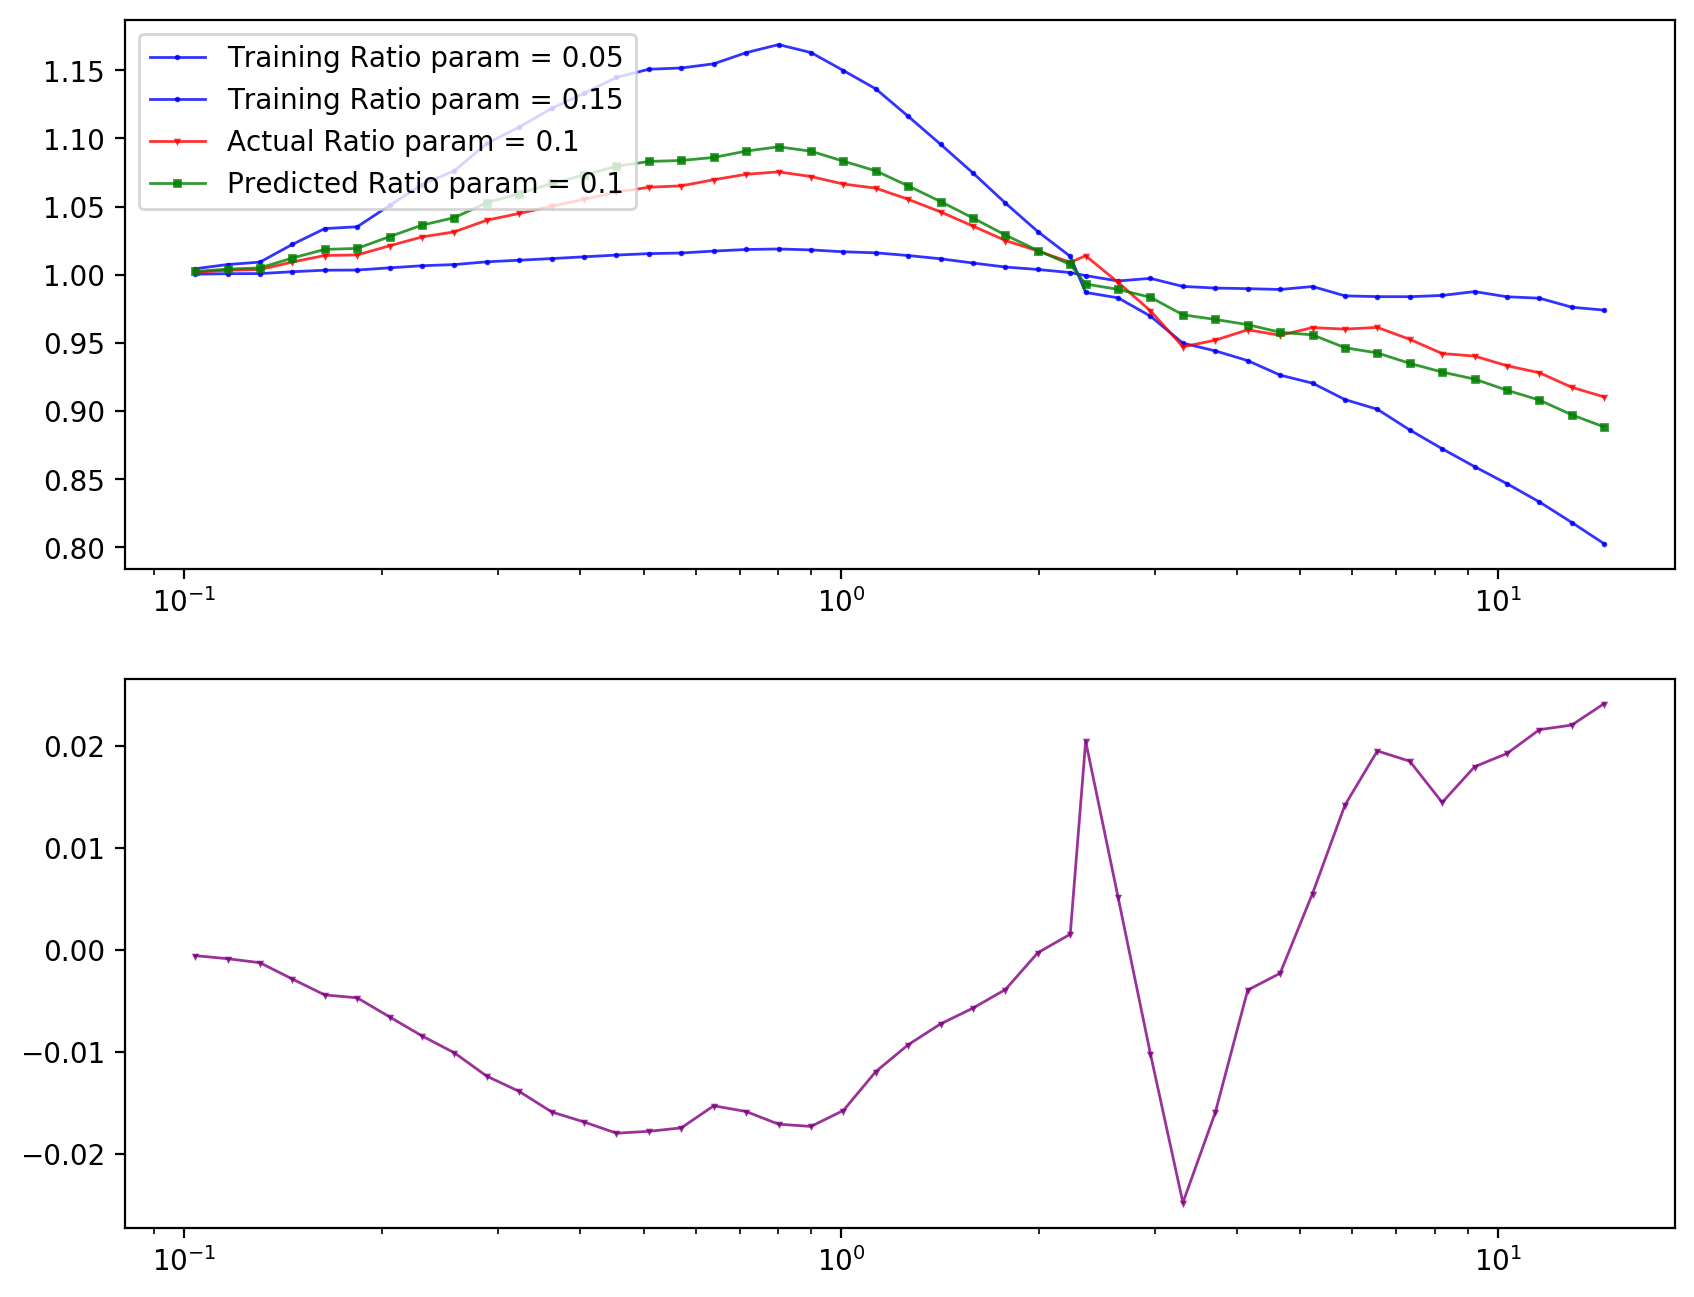

In [31]:
##########################
####Mask large scale####
##########################

linkgrid = np.power(10, emulation_data.k_grid)
mask = np.where(linkgrid >0.1)[0]
GLOBAL_applymask = True
thinning = 1


emulation_data.calculate_data_split(n_train=n_train, n_test=n_test, 
                                    n_splits=1, verbosity=3,num_percentiles=5);

emulation_data.data_split(split_index=0,thinning=thinning, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=2)


##########################
####PCA and prediction####
##########################

PCAop = dcl.LearningOperator('PCA', ncomp=npca, interp_type='int1d')
intobj = dcl.LearnData(PCAop)

###Perfoming the PCA reduction and interpolation 
intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted)
intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
                
intobj.print_statistics()

# GP example

('number of wanted training vectors', 0)
('number of wanted test vectors', 1)
('number of obtained training vectors', 2)
('number of obtained validation vectors', 0)
('number of obtained test vectors', 1)
 global mean min error:  0.00041029608699501367 
 global mean max error:  0.02593656870891474 
 global max rmse:  0.01413568467928451 
 global mean rmse:  0.01413568467928451 
 global var rmse:  0.0


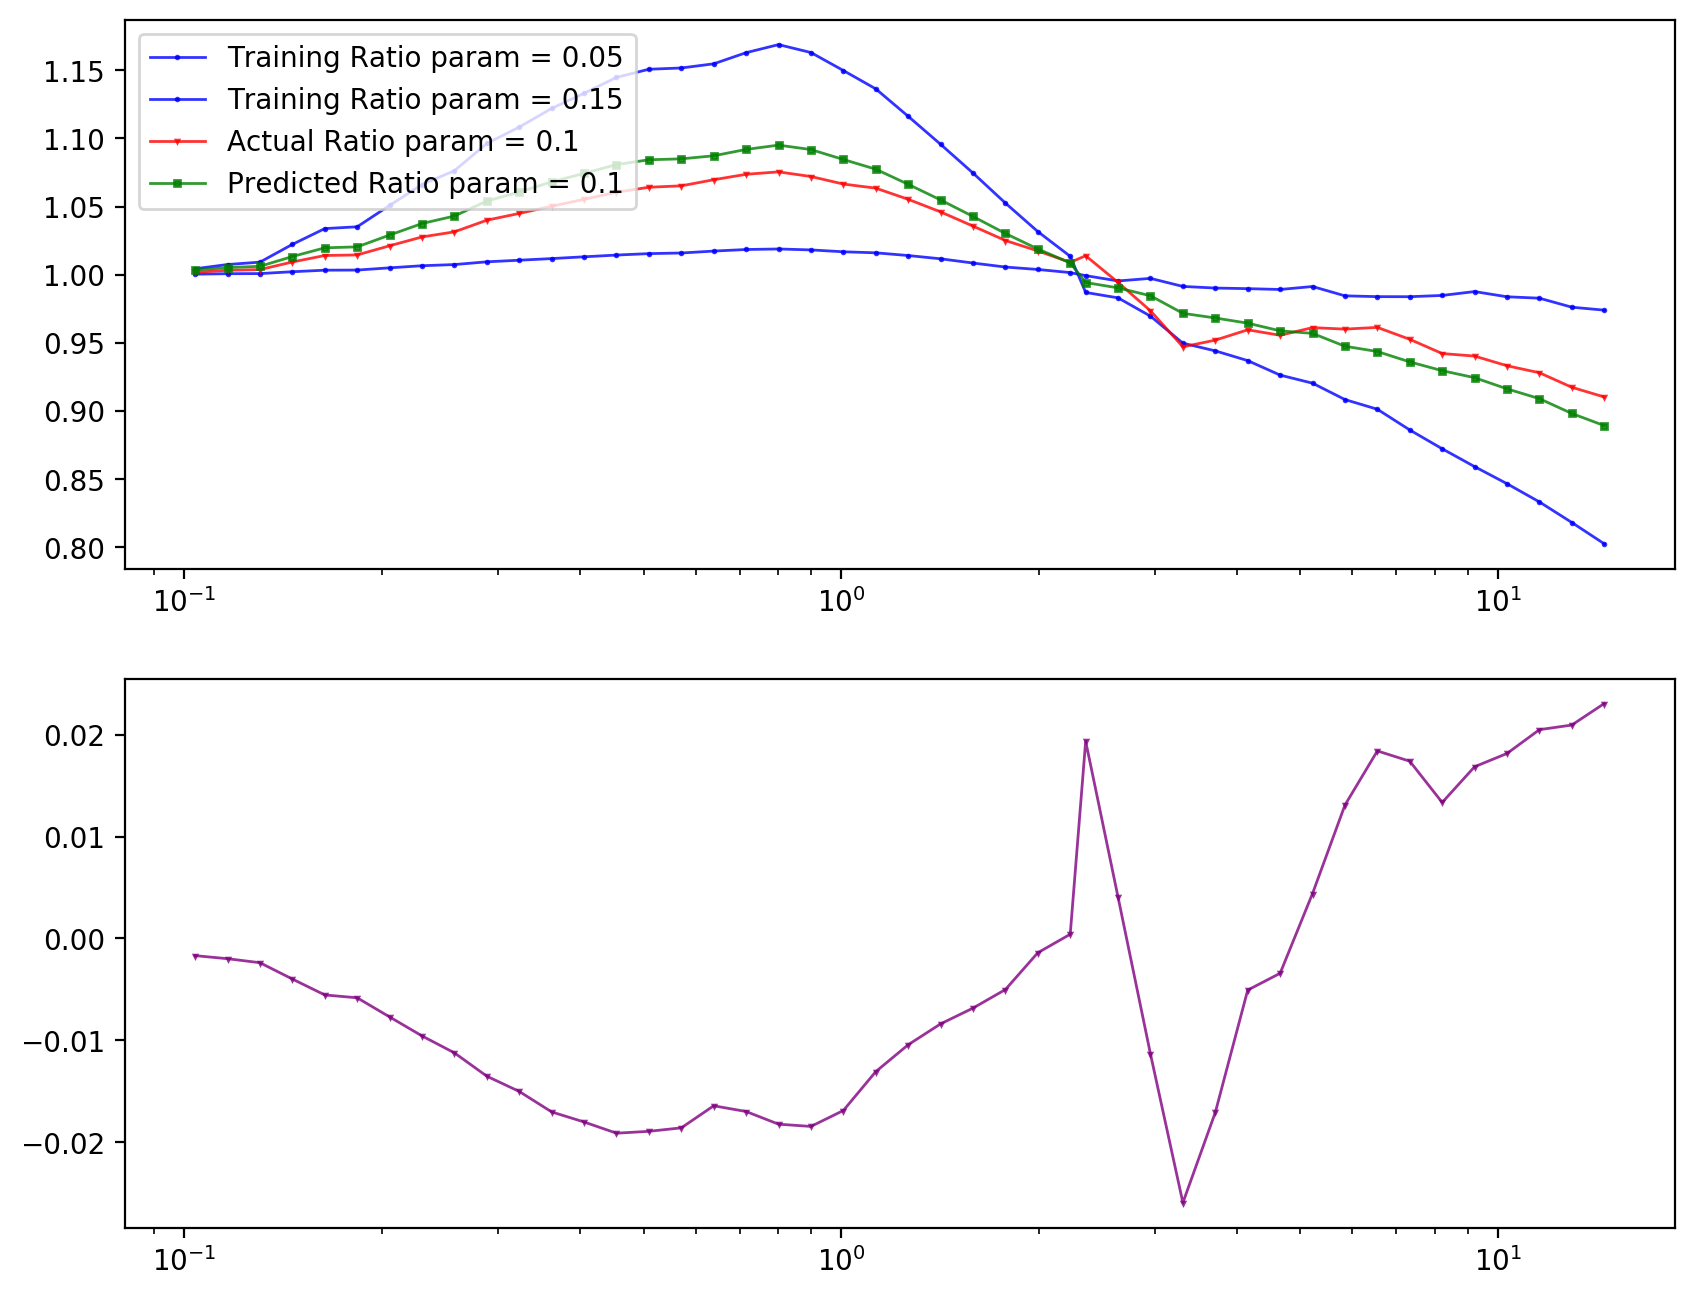

In [32]:

emulation_data.calculate_data_split(n_train=n_train, n_test=n_test, 
                                    n_splits=1, verbosity=3,num_percentiles=5);

emulation_data.data_split(split_index=0,thinning=thinning, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=2)
GPop = dcl.LearningOperator('GP')
intobj = dcl.LearnData(GPop)

###Perfoming the PCA reduction and interpolation 
intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted)

intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
intobj.print_statistics()